In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import RMSprop
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D
from keras.applications import DenseNet121 # Modelos de aprendizado profundo


from keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.



Using TensorFlow backend.


['iwild32x32', 'densenet-keras', 'iwildcam-2019-fgvc6']


In [2]:
df = pd.read_csv('../input/iwildcam-2019-fgvc6/train.csv')
df.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


### Existe uma quantidade muito alta de fotos sem animais

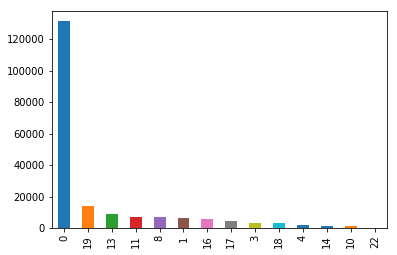

In [3]:
df['category_id'].value_counts().plot(kind='bar');

### Mostrando apenas para os que tem animais
###### O label 22 (mountain_lion) possui apenas 33 instâncias

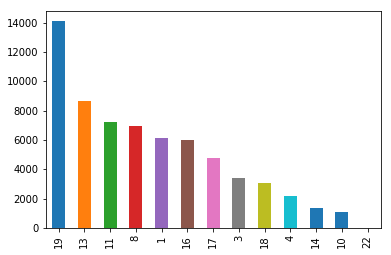

In [4]:
df['category_id'][df.category_id != 0].value_counts().plot(kind='bar');

In [5]:
# Removendo colunas desnecessárias
df.drop(columns=['date_captured', 'frame_num', 'id','location', 'rights_holder', 'seq_id', 'seq_num_frames', 'width', 'height'], inplace=True)

In [6]:
df.head()

,category_id,file_name
0,19,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg
1,19,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg
2,0,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg
3,0,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg
4,0,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg


In [7]:
# Aleatorizando todo o Dataframe
df = df.sample(frac=1).reset_index(drop=True)
# Retornando a quantidade de classes que existem no treino
quantidade_categorias = len(df['category_id'].unique())
quantidade_categorias

14

### Pegando o dataset das imagens trans formadas em 32x32

In [8]:
x_train = np.load('../input/iwild32x32/X_train.npy')
x_test = np.load('../input/iwild32x32/X_test.npy')
y_train = np.load('../input/iwild32x32/y_train.npy')

Transformando as imagens de 32x32 para floats de 0 a 1

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

### Métrica

In [10]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

### Definindo o método para imprimir os gráficos

In [11]:
def plotResult(result):
    acc = result.history['acc']
    val_acc = result.history['val_acc']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    fig, ax = plt.subplots(1,2, figsize=(18,4))
    
    ax[0].plot(epochs, acc, label='Training')
    ax[0].plot(epochs, val_acc, label='Validation')
    ax[0].set_title('Training and validation Accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, label='Training')
    ax[1].plot(epochs, val_loss, label='Validation')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
        
    plt.show()

O modelo é salvo a cada época em que a sua performance é melhorada

In [12]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

### Definindo o modelo e treinando

In [13]:
model = Sequential()
model.add(DenseNet121(weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
                      include_top=False,
                      input_shape=(32,32,3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(quantidade_categorias, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()
results = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=35,
    callbacks=[checkpoint, f1_metrics],
    validation_split=.2
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                14350     
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________
Train on 157039 samples, validate on 39260 samples
Epoch 1/35
157039/157039 [==============================] - 439s 3ms/step - loss: 0.6376 - acc: 0.7969 - val_loss: 0.5219 - val_acc: 0.8299

Epoch 00001: val_acc improved from -inf to 0.82993, saving model to model.h5


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val_f1: 0.4636 — val_precision: 0.5704 — val_recall: 0.4296
Epoch 2/35
157039/157039 [==============================] - 412s 3ms/step - loss: 0.5143 - acc: 0.8311 - val_loss: 0.5277 - val_acc: 0.8421

Epoch 00002: val_acc improved from 0.82993 to 0.84210, saving model to model.h5
val_f1: 0.5034 — val_precision: 0.6067 — val_recall: 0.4851
Epoch 3/35
 66496/157039 [===========>..................] - ETA: 3:49 - loss: 0.4306 - acc: 0.8596

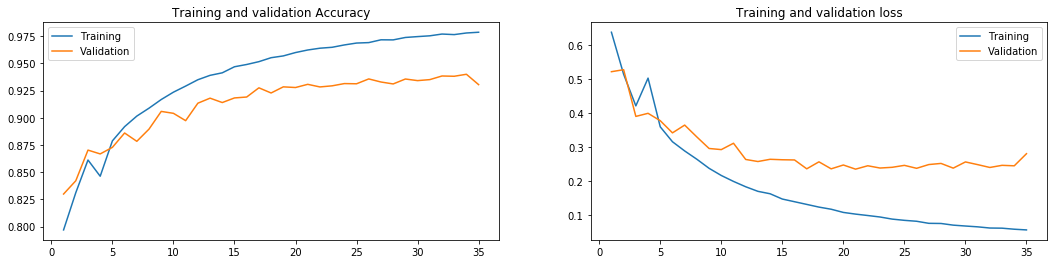

In [14]:
plotResult(results)

### Submissão

In [15]:
model.load_weights('model.h5')
y_test = model.predict(x_test)
submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)

print(submission_df.shape)
submission_df.head(3)

(153730, 2)


,Id,Predicted
0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0
1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0
2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0


In [16]:
submission_df.to_csv("submission.csv", index=False)